# Mixture Density Networks in GPflow

In this tutorial, we'll implement a Mixture Density Network (MDN) [1] in GPflow. This post is very similar to a [blogpost](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) from 2015, but instead of directly using TensorFlow we'll use GPflow. GPflow is typically used for building Gaussian Process based models but the framework contains tons of useful methods and classes that can be used to quickly prototype a wide variety of ML algorithms. Excellent for doing research!

This post is organized as follows. We start by giving a quick motivation of why MDNs can be useful. We then go over a GPflow implementation of the model and use it for a couple of toy experiments.

## Conditional Density Estimation

Imagine for a moment that we are interested in performing regression on the following dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

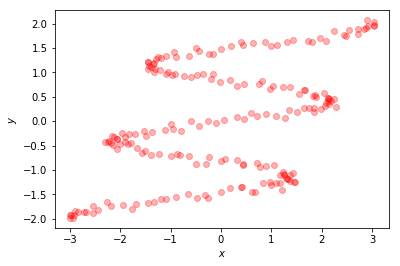

In [2]:
N = 200
NOISE_STD = 5.0e-2

def sinusoidal_data(N, noise):
    Y = np.linspace(-2, 2, N)[:, None]
    X = np.sin(4 * Y) * 2.0 + Y * 0.5
    X += np.random.randn(N, 1) * noise
    Y += np.random.randn(N, 1) * noise
    return X, Y

X, Y = sinusoidal_data(N, NOISE_STD)
plt.plot(X, Y,'ro', alpha=0.3);
plt.xlabel("$x$");
plt.ylabel("$y$");

At first sight, this dataset doesn't look too scary, both input and output are single dimensional and the data has a clear sinusoidal pattern. However, we notice that a single input $x$ can correspond to multiple output values $y$. For example, for $x=0$ the output can be on of the values $\{-1.5, -3/4, 0, 0.8, 1.5\}$. Typical regression algorithms such as Linear Regression, Gaussian processes regression, Multilayer Perceptrons (MLPs), etc would struggle with this as they predict only one value for every input.

To model a dataset like this we will use Conditional Density Estimation (CDE) models. CDE models deal with inferring $p(f(x)|x)$ instead of only calculating only the expectation $E[f(x) | x]$. Modeling the complete distribution $p(f(x)|x)$ is typically harder but it reveals much more interesting properties, such as the modes, outlier boundaries and samples. A real-world example where CDE is required is the modeling of taxi drop-offs conditioned on the pick-up location. We would expect a taxi drop-off location to be multi-modal as passengers need to go to different places (e.g. airport/city center/suburbs) and that the density depends on the starting location [2]. 

## Mixture Density Models

Mixture density networks (MDNs) are a parametric class of models that allow for conditional density estimation. They are built out of 2 parts: a neural net and a Mixture of Gaussians (MoG). The neural net is  responsible for producing the characteristics of the MoG. In practice, given that the MoG consists of $M$ Gaussians, the neural net will output a collection of $M$ means, variances and weights $\{\mu_m, \sigma_m^2, \pi_m\}_{m=1}^M$. The produced means, variances and weights are used to define the conditional probability distribution function 
$$
p(Y = y\,|\,X = x) = \sum_{m=1}^{M} \pi_{m}(x)\,\mathcal{N}\big(y\, \left|\,\mu_{m}(x), \sigma_{m}^2(x)\big)\right.
$$
Each of the parameters  $\pi_{m}(x), \mu_{m}(x), \sigma_{m}(x)$ of the distribution will be determined by the neural network, as a function of the input $x$.

We train the MDN's neural net by optimizing the model's likelihood
$$
 \mathcal{L} \triangleq \operatorname{argmax}_{\Theta} \prod_{n=1}^N p(Y = y_n\,|\,X = x_n),
$$
where $\Theta$ collects the neural nets weights and biases and $\{x_n, y_n\}_{n=1}^N$ are our training dataset.

## GPflow MDN implementation

GPflow doesn't reinvent the wheel: most of what you will see is just plain Python/TensorFlow code. We choose to use GPflow, however, because it provides us with some functionality to easily define a model. Once we have a GPflow model, we can specify its objective function, parameters, dataset. This extra layer of abstraction makes interacting with the model, such as optimizing or performing inference, much easier. 

We begin by importing the required packages from TensorFlow and GPflow

In [3]:
import tensorflow as tf
from scipy.stats import norm

In [4]:
import gpflow
from gpflow.models.model import Model
from gpflow.params.dataholders import Minibatch, DataHolder
from gpflow.params import Parameter, ParamList
from gpflow.training import AdamOptimizer, ScipyOptimizer
from gpflow.decors import params_as_tensors, autoflow

float_type = gpflow.settings.float_type

We continue by creating a `MDN` class which inherits from GPflow's `model` class. We now need to do the following things:
1. Store the feature and target matrices (X, Y) as `DataHolders`.
2. Define our model's parameters using GPflow's `Parameter` and `ParamList` objects.
3. Define the objective function. In the `_build_likelood` function we need to specify our model's objective function. When we optimize the model the negative of this function will be minimized. 

In [5]:
class MDN(Model):
    
    def __init__(self, X, Y, inner_dims=[10, 10,], activation=tf.nn.tanh, num_mixtures=5):
        Model.__init__(self)
        
        self.Din = X.shape[1]
        self.dims = [self.Din, ] + list(inner_dims) + [3 * num_mixtures]
        self.activation = activation

        self.X = DataHolder(X)
        self.Y = DataHolder(Y)

        self._create_network()
        
    def _create_network(self):
        Ws, bs = [], []
        for dim_in, dim_out in zip(self.dims[:-1], self.dims[1:]):
            init_xavier_std = (2.0 / (dim_in + dim_out)) ** 0.5
            Ws.append(Parameter(np.random.randn(dim_in, dim_out) * init_xavier_std))
            bs.append(Parameter(np.zeros(dim_out)))

        self.Ws, self.bs = ParamList(Ws), ParamList(bs)

    @params_as_tensors
    def _eval_network(self, X):
        for i, (W, b) in enumerate(zip(self.Ws, self.bs)):
            X = tf.matmul(X, W) + b
            if i < len(self.bs) - 1:
                X = self.activation(X)

        pis, mus, sigmas = tf.split(X, 3, axis=1)
        pis = tf.nn.softmax(pis)  # make sure they normalize to 1
        sigmas = tf.exp(sigmas)   # make sure std. dev. are positive
        
        return pis, mus, sigmas

    @params_as_tensors
    def _build_likelihood(self):
        pis, mus, sigmas = self._eval_network(self.X)
        Z = (2 * np.pi)**0.5 * sigmas
        log_probs_mog = (-0.5 * (mus - self.Y)**2 / sigmas**2) - tf.log(Z) + tf.log(pis)
        log_probs = tf.reduce_logsumexp(log_probs_mog, axis=1)
        return tf.reduce_sum(log_probs)
    
    @autoflow((float_type, [None, None]))
    def eval_network(self, X):
        pis, mus, sigmas = self._eval_network(X)
        return pis, mus, sigmas

### Notes
- Given that we are dealing with a MoG, the neural net output must comply with the following restrictions:
   $\sum_{m=1}^{M} \pi_{m}(x) = 1$, $\pi_m \ge 0$ and $\sigma_m\ \forall\ m$.
    We achieve this by applying the `softmax` operator to the $\pi$'s and by taking the `exp` to the $\sigma$'s.

- We use the "Xavier" initialization for the neural network's weights. (Glorot and Bengio, 2010).

- Instead of calculating the pdf of the Gaussians, we work with the `log` of the pdf and use `tf.reduce_logsumexp`. This is mainly for numerical stability.

### GPflow insides

- Notice that we store vanilla numpy arrays in `Parameter` and `DataHolder` objects. The `@params_as_tensors` decorator will make sure that these variables are transformed into TensorFlow tensors once we are inside the decorated method.
- The `@autoflow` decorator specifies the type and shape of a method's input variables. It will make sure that the graph, constructed inside the decorated method, will be executed inside a TF session and that the output is returned as a `np.array` when the method is called. This decorator allows one to execute TF graphs without having to worry about managing any `tf.session` objects, nor creating any placeholders or other TF related objects.

## Experiments

Let's see how our model works in practice. We will start with modeling the sinusoidal dataset we showed earlier. We do this by initializing a new instance of our MDN model. We further specify the dataset $(X, Y)$, the number of hidden units of the MDN's neural net and the number of mixture components $M$.

In [6]:
model = MDN(X, Y, inner_dims=[100, 100], num_mixtures=25)

MDN instances are aware of their objective function. We can therefore directly start with minimizing the model. GPflow will make sure that only the variables stored as `Parameters` will be optimized. For the MDN the only parameters are the weights and the biases of the neural net, we stored them in `ParamList`s `self.Ws` and `self.bs`.

We are using the `ScipyOptimizer`, which is a wrapper around scipy's L-BFGS optimization algorithm. GPflow, however, supports all other TensorFlow optimizers, such as `Adam`, `Adagrad`, `Adadelta`, ... as well.

In [7]:
from gpflow.test_util import notebook_niter
ScipyOptimizer().minimize(model, maxiter=notebook_niter(1500))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -37.810713
  Number of iterations: 1500
  Number of functions evaluations: 1734


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -37.810713
  Number of iterations: 1500
  Number of functions evaluations: 1734


To evaluate the validity of our model we will draw the posterior density. We also plot $\mu(x)$ of the optimized neural net. Remember that for every $x$ the neural net will output, among other, $M$ means $\mu_m(x)$. They determine the location of the Gaussians. We plot all $M$ of those means and use their corresponding mixture weight $\pi_m(X)$ to determine their size. Larger dots will have more impact in the Gaussian ensemble. 

In [8]:
CM = plt.get_cmap('Blues')
N_plot = 100

def make_grid(xx, yy):
    """ 
    Returns two n-by-n matrices. The first one contains all the x values 
    and the second all the y values of a cartesian product between `xx` and `yy`.
    """
    n = len(xx)
    xx, yy = np.meshgrid(xx, yy)
    grid = np.array([xx.ravel(), yy.ravel()]).T
    x = grid[:, 0].reshape(n, n)
    y = grid[:, 1].reshape(n, n)
    return x, y

def plot(model, X, Y, axes):
    xx = np.linspace(X.min() - 1, X.max() + 1, N_plot)[:, None]
    yy = np.linspace(Y.min() - 1, Y.max() + 1, N_plot)
    
    pis, mus, sigmas = model.eval_network(xx)

    probs = norm.pdf(yy[:, None, None], loc=mus[None, :, :], scale=sigmas[None, :, :])
    probs = np.sum(probs * pis[None, :, :], axis=-1)
    
    plot_x, plot_y = make_grid(xx, yy)
    axes[0].set_title("Posterior density and trainings data")
    axes[0].contourf(plot_x, plot_y, np.log(probs), 500, cmap=CM, vmin=-5, vmax=5)
    axes[0].plot(X, Y,'ro', alpha=0.2, ms=3, label="data")
    axes[0].legend(loc=4)
    
    axes[1].set_title("$\mu_m(x)$ and their relative contribution shown by size")
    axes[1].scatter(np.repeat(xx.flatten(), repeats=mus.shape[1]), 
                    mus.flatten(), 
                    s=pis.flatten()*20)

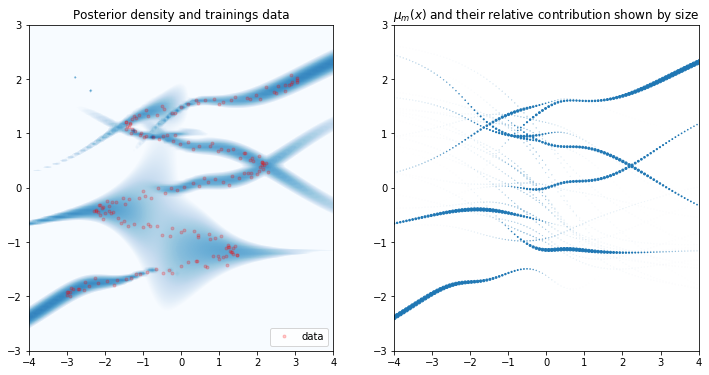

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for a in axes:
    a.set_xlim(-4, 4)
    a.set_ylim(-3, 3)
plot(model, X, Y, axes)

### Lets try another dataset

This dataset is known as the two half moon dataset. It is available in the scikit-learn package.

In [10]:
from sklearn.datasets import make_moons

def moon_data(N, noise):
    data, _ = make_moons(n_samples=N, shuffle=True, noise=noise)
    X, Y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
    return X, Y

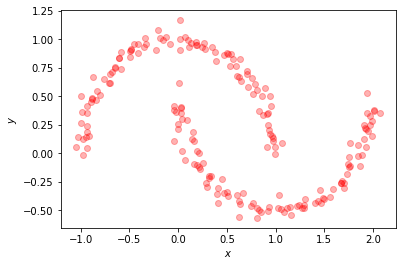

In [11]:
X, Y = moon_data(N, NOISE_STD)
plt.plot(X, Y,'ro', alpha=0.3);
plt.xlabel("$x$");
plt.ylabel("$y$");

The only difference in the MDN's setup is that we lower the number of mixture components.

In [12]:
model = MDN(X, Y, inner_dims=[100, 100], num_mixtures=5)

In [13]:
ScipyOptimizer().minimize(model, maxiter=10000)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -207.417572
  Number of iterations: 10000
  Number of functions evaluations: 11622


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -207.417572
  Number of iterations: 10000
  Number of functions evaluations: 11622


/home/vincent/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


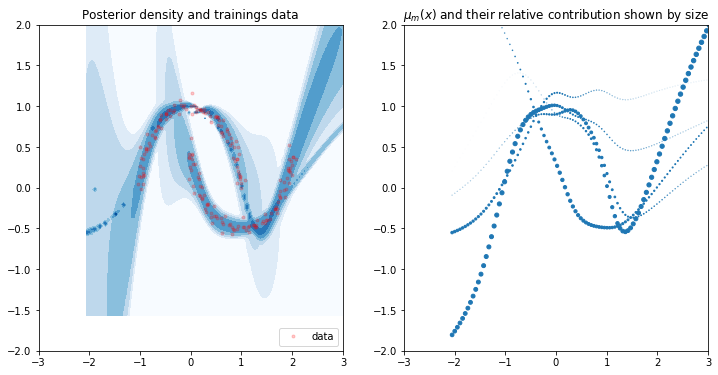

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for a in axes:
    a.set_xlim(-3, 3)
    a.set_ylim(-2, 2)
plot(model, X, Y, axes)

## Quick glance at other generally useful GPflow functionality


#### 1. Minibatching

Let's wrap up by giving you a glance of some of the other things you can do with GPflow.
For example, if our dataset would become too large so that training the neural net over the complete dataset becomes infeasible, we can simply use `Minibatches` instead of `DataHolders`.

In [15]:
class MDN_minibatching(Model):
    
    def __init__(self, X, Y, *args, **kwargs):
        MDN.__init__(X, Y, *args, **kwargs)
        self.X = Minibatch(X, batch_size=1000, seed=0)
        self.Y = Minibatch(Y, batch_size=1000, seed=0)

This minor change can have huge impact on performance. It will make sure that every time we use `self.X` and `self.Y` inside our model's methods, we are actually working with a random subset of `1000` points from our initial dataset.

#### 2. Constrained parameters

Imagine for a second we wish to constrain our neural net biases (or for that matter any another parameter) to always be positive. In plain TensorFlow, imposing such constraints isn't straightforward at all. In GP models, however, we are often faced with this. Model parameters, such as a kernel variance or lengthscale, can't go negative during optimization. For this reason, GPflow implements a series of `Transforms` that can be imposed on `Parameter` objects. For example, declaring a parameter as follows will make sure that its optimized value is positive.

In [16]:
bias_always_postive = Parameter(np.zeros(5), transform=gpflow.transforms.positive)

#### 3. Fixing parameters

Sometimes we don't want to optimize all the model's parameters. Or, we want to interleave optimizing a neural net's weights and biases. GPflow provides functionality to set specific parameters untrainable.

For example,

In [17]:
# Only optimize the biases for 1000 iterations
model.Ws.set_trainable(False)
model.bs.set_trainable(True)
ScipyOptimizer().minimize(model, maxiter=1000)
# Continue, but only optimize the weights now
model.Ws.set_trainable(True)
model.bs.set_trainable(False)
ScipyOptimizer().minimize(model, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.322892
  Number of iterations: 264
  Number of functions evaluations: 320


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.322892
  Number of iterations: 264
  Number of functions evaluations: 320


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.803572
  Number of iterations: 241
  Number of functions evaluations: 302


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.803572
  Number of iterations: 241
  Number of functions evaluations: 302


#### 4. Printing

Printing all variables of the model can also be a useful feature. Apart from their value, we also get the shape, prior, transform, etc.

In [18]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
MDN/Ws/0,Parameter,None,(none),True,"(1, 100)",True,"[[0.1720881510405538, 0.24519227128093082, -0...."
MDN/Ws/1,Parameter,None,(none),True,"(100, 100)",True,"[[-0.1260119091075435, 0.056030335553334275, 0..."
MDN/Ws/2,Parameter,None,(none),True,"(100, 15)",True,"[[0.6392741496715273, 0.2563334451642676, -0.0..."
MDN/bs/0,Parameter,None,(none),False,"(100,)",True,"[0.3008476434850683, 0.026525580078305626, -0...."
MDN/bs/1,Parameter,None,(none),False,"(100,)",True,"[0.2805733881050625, -0.11294624798391358, -0...."
MDN/bs/2,Parameter,None,(none),False,"(15,)",True,"[0.12665487078819385, 0.0600429066677119, -0.1..."


### References

[1] Bishop, Christopher M. Mixture density networks. Technical Report NCRG/4288, Aston University, Birmingham, UK, 1994.

[2] Dutordoir, Vincent, et al. "Gaussian Process Conditional Density Estimation." Advances in Neural Information Processing Systems. 2018.